# Facial Age Estimation Model

 Our Facial Age Estimation Model is built and designed to predict the age of individuals based on facial images.
 
 The model is custom Convolutional Neural Network (CNN) architecture" and a "VGG-like" model or a "custom variation of the VGG architecture since it shares some similarities in terms of using multiple convolutional layers followed by pooling layers and fully connected layers. 

#### and the following steps are used to build it:

#### Step 1 - Importing Required Libraries

In [1]:
import numpy as np 
import pandas as pd
from glob import glob 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
import os
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-10-15 22:11:59.444536: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Step 2 - Reading the Images 


In [2]:
# Define the paths to the train, test, and validation data
train_path = 'FDB/train'
test_path = 'FDB/test'
valid_path = 'FDB/validation'

# Define the image size and Batch size
IMAGE_SIZE = [224, 224]
batch_size = 32


# Get a list of folders in the train_path
folders = glob(os.path.join(train_path, '*'))

# Define the class labels based on your desired mapping
class_labels = ['0-3', '12+', '17+', '4+', '9+']

# Create a dictionary to map class labels to one-hot encodings
class_labels_dict = {label: [int(label == class_label) for class_label in class_labels] for label in class_labels}

# Print the class labels and their one-hot encodings
for class_label, hot_code in class_labels_dict.items():
    print(f'Class Label: {class_label} - Hot Code: {hot_code}')
print(class_labels)

Class Label: 0-3 - Hot Code: [1, 0, 0, 0, 0]
Class Label: 12+ - Hot Code: [0, 1, 0, 0, 0]
Class Label: 17+ - Hot Code: [0, 0, 1, 0, 0]
Class Label: 4+ - Hot Code: [0, 0, 0, 1, 0]
Class Label: 9+ - Hot Code: [0, 0, 0, 0, 1]
['0-3', '12+', '17+', '4+', '9+']


#### Step 3 Pixel Value Normalization, ImageDataGenerator and creating Data Generators


In [18]:
#  Pixel Value Normalization , it rescales the pixel values so that they fall within the range [0, 1].
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data Generators
training_set = train_datagen.flow_from_directory(train_path, 
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

validation_set = validation_datagen.flow_from_directory(valid_path,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = IMAGE_SIZE,
                                            batch_size = batch_size,
                                            class_mode = 'categorical')

Found 7039 images belonging to 5 classes.
Found 1208 images belonging to 5 classes.
Found 1213 images belonging to 5 classes.


#### Step 4 - Building the CNN Model and compiling it and # Early Stopping and Learning Rate Schedule 


In [4]:

# Building the model
input_layer = Input(shape=(224, 224, 3))

# Convolutional Block 1
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Flatten and Fully Connected Layers with Dropout
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  
x = BatchNormalization()(x)
x = Dropout(0.7)(x)

# Output Layer
output_layer = Dense(5, activation='softmax')(x)  

# Create the model
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

# Compiling the Model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


# Early Stopping and Learning Rate Schedule
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 401408)            0         
                                                                 
 dense (Dense)               (None, 128)               513803

#### Step 5 - Training the Model


In [5]:
epochs = 30
history = model.fit(
    training_set,
    steps_per_epoch=len(training_set),
    validation_data=validation_set,
    validation_steps=len(validation_set),
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


2023-10-15 22:12:12.084868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


220/220 [==============================] - ETA: 0s - loss: 7.2312 - accuracy: 0.4361

2023-10-15 22:14:34.124711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


220/220 [==============================] - 148s 664ms/step - loss: 7.2312 - accuracy: 0.4361 - val_loss: 3.1515 - val_accuracy: 0.6184 - lr: 0.0010
Epoch 2/30
220/220 [==============================] - 147s 668ms/step - loss: 2.8700 - accuracy: 0.5079 - val_loss: 2.5148 - val_accuracy: 0.4222 - lr: 0.0010
Epoch 3/30
220/220 [==============================] - 140s 635ms/step - loss: 2.6792 - accuracy: 0.5549 - val_loss: 3.2389 - val_accuracy: 0.2260 - lr: 0.0010
Epoch 4/30
220/220 [==============================] - 140s 635ms/step - loss: 2.4849 - accuracy: 0.6028 - val_loss: 3.1062 - val_accuracy: 0.4636 - lr: 0.0010
Epoch 5/30
220/220 [==============================] - 132s 600ms/step - loss: 2.0810 - accuracy: 0.6994 - val_loss: 1.4925 - val_accuracy: 0.8137 - lr: 1.0000e-04
Epoch 6/30
220/220 [==============================] - 129s 584ms/step - loss: 1.4114 - accuracy: 0.7252 - val_loss: 1.1775 - val_accuracy: 0.7906 - lr: 1.0000e-04
Epoch 7/30
220/220 [=============================

#### Step 6 - Evaluating the Model

2023-10-15 23:57:12.554420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


38/38 [==============================] - 8s 214ms/step - loss: 0.5930 - accuracy: 0.8368
Test Loss: 0.5930192470550537
Test Accuracy: 0.8367683291435242
1/1 [==============================] - 0s 341ms/step


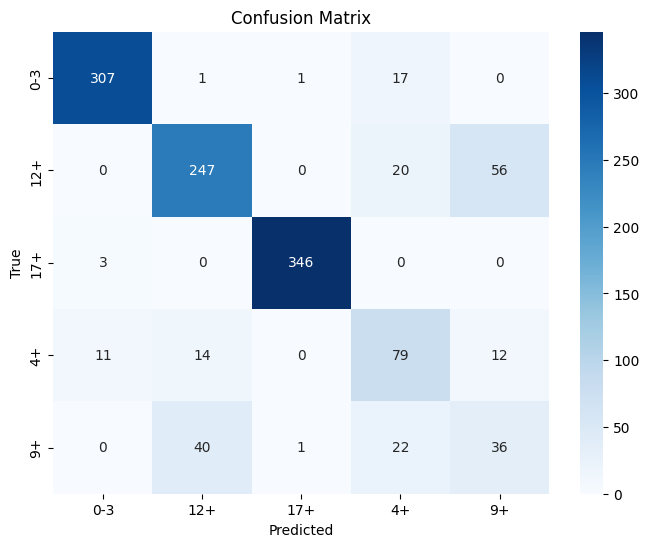

              precision    recall  f1-score   support

         0-3       0.96      0.94      0.95       326
         12+       0.82      0.76      0.79       323
         17+       0.99      0.99      0.99       349
          4+       0.57      0.68      0.62       116
          9+       0.35      0.36      0.35        99

    accuracy                           0.84      1213
   macro avg       0.74      0.75      0.74      1213
weighted avg       0.84      0.84      0.84      1213



In [20]:

# Evaluate the Model on the Test Set
test_loss, test_acc = model.evaluate(test_set, steps=len(test_set))
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

# Model Evaluation and Confusion Matrix
# Initialize variables to store true and predicted labels
true_labels = []
predicted_labels = []

# Loop through the test set and make predictions
for i in range(len(test_set)):
    images, labels = test_set[i]
    true_labels.extend(np.argmax(labels, axis=1))
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Convert the lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create the confusion matrix
confusion_mtx = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print(report)

#### Step 7 - Plotting Loss and Accuracy Curves

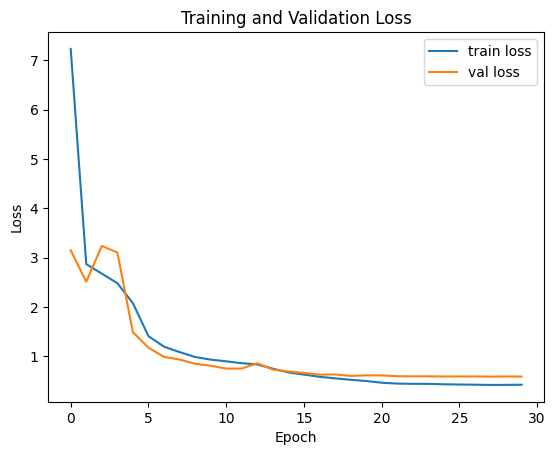

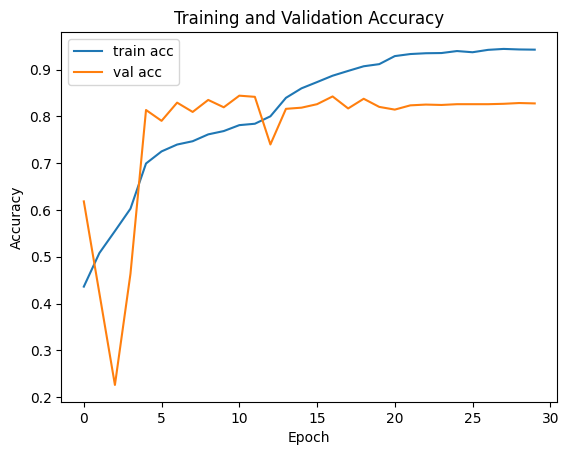

In [21]:
# Plotting Loss Curves
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# Plotting Accuracy Curves
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

#### Step 8 and the last one- Saving the Model

In [22]:
# Saving the Model
model.save('AgeEstimation_Model_Best.h5')

##### The model exhibits promising training progress, achieving an accuracy of around 0.8368 on the test data. The model is saved for use on our website.